# 背景概述

$\quad$**对映选择性**(enantioselectivity)是有机化学重要的研究主题之一. 在有机反应中, 手性催化剂的对映选择性往往与反应过渡态中一些重要的**非共价相互作用**(non-covalent interactions, NCIs)有关. 以[Birman等](https://pubs.acs.org/doi/10.1021/ja0491477)报道的酰基转移反应为例:

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/6691c6d5302140c582b7343f24173c5d/bSUHb1WG1pR3NNhIsLuhDA.png)

在Birman等假设的机理中, 手性催化剂的对映选择性由$\pi$-$\pi$堆积或$\pi$-阳离子堆积作用介导, 特定手性的过渡态因位阻作用导致两个芳环不平行, 不利于堆积作用的形成.

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/e1edd4976ba44a58b0952756aeb950fd/RDAnx-oUTRUK7MbgTA6CPw.png)

$\quad$本次上机作业中, 我们将以线性回归模型定量地探索所用手性催化剂的性质对对映选择性的影响, 试图揭示: (1) 哪些性质参数会影响对映选择性? (2) 如何优化性质参数可以提升对映选择性 (例如减少还是增加某参数)? 为此, 我们将考察如下图所示的模型体系:

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/ad92a2cb3d0040ffbde82802641d5a39/uz3674Qv_rCWWOAd9DpFTw.png)

其中, 底物的芳香环(**A**, **a**, **b**)按照特定的几何约束条件与催化剂(**D**, **c**, **d**)排列成复合物, 而芳环与底物的其余分子骨架(包含醇羟基和烷基)在图中箭头所示位置相连.

- 参考文献: [J. Am. Chem. Soc. 2017, 139, 20, 6803–6806](https://pubs.acs.org/doi/10.1021/jacs.7b02311)

# 数据探索与清洗

## 数据的初步探索

$\quad$在数据集`nci_birman.csv`中, 包含如下三组(用作特征的)参数:
- $\pi$-$\pi$堆积作用参数: `d_pi_d`, `d_pi_D`, `e_pi_d`, `e_pi_D`. 根据特定的电子结构计算方法(B97-D/def2TZVP水平), 对复合物进行几何优化, 给出几何结构信息与互作能(复合物能量减去各组分能量和). 其中:
  - 每组复合物中, 底物芳环由于具体朝向的不同, 存在2种可能构象(比如下图的例子), 分别以后缀`_d`和`_D`作区分;
    ![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/842ed157585c4e4a8ba62ad2b91cf582/tUoBI8UPrb1b5S2Z1R3WHw.png)
  - 在计算中, 对底物与催化剂分子的两个芳环施加约束条件, 使二者完全“正对彼此”(环平面平行, 且两环中心的连线与环平面垂直). 此时, 我们找到使电子能量(前缀`e_`, 单位kcal/mol)最低的、也就是使复合物最稳定的环间距(前缀`d_`, 单位Å)
- 烷基几何参数: `L_Alk`, `B1_Alk`, `B5_Alk`, 分别代表长度、最大宽度、最小宽度.
- 芳环几何参数: `L_Ar`, `B1_Ar`, `B5_Ar`, 分别代表长度、最大宽度、最小宽度.
后两组参数称为[**Sterimol参数**](https://en.wikipedia.org/wiki/Sterimol_parameter), 其具体含义可从下图中做简单的理解:

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/842ed157585c4e4a8ba62ad2b91cf582/zpobYlZXNb5KHS_mwjLSBA.png)

$\quad$我们的线性回归模型将以上述参数作为特征(在化学信息学中, 这些特征也常称为**描述符**, descriptor), 试图预测特定催化剂针对特定底物的对映选择性. 在数据集中, 选择性以**对映比**$er$描述, 这是一个实验可测的量. 通过热力学公式, 我们可以将其与两种对映体的活化自由能之差$\Delta\Delta G^\ddagger$之间建立定量联系:

$$
\Delta\Delta G^\ddagger = -RT\ln{(er)}.
$$

In [2]:
import pandas as pd
nci_birman = pd.read_csv("./nci_birman.csv", sep="\t")
nci_birman.iloc[:5, :]

,d_pi_d,d_pi_D,e_pi_d,e_pi_D,L_Alk,B1_Alk,B5_Alk,L_Ar,B1_Ar,B5_Ar,er(%)
0,3.54,3.54,-10.24,-10.24,4.36,2.92,3.35,6.38,1.77,3.15,1.71
1,3.54,3.54,-10.24,-10.24,4.35,2.09,3.34,6.38,1.77,3.15,3.36
2,3.54,3.54,-10.24,-10.24,4.38,1.73,3.33,6.38,1.77,3.15,3.78
3,3.54,3.54,-10.24,-10.24,3.08,1.70,2.20,6.38,1.77,3.15,5.03
4,3.49,3.49,-11.88,-11.88,3.08,1.70,2.20,6.38,1.88,4.52,5.03


## 数据的清洗与加工

$\quad$对于堆积相互作用参数, 我们不妨对其进行降维: 取两个可能构象`_d`和`_D`的参数加权和:
$$\begin{aligned}
D\pi_\mathrm{w} &:= c_\mathrm{d}D\pi_\mathrm{d} + c_\mathrm{D}D\pi_\mathrm{D},\\
E\pi_\mathrm{w} &:= c_\mathrm{d}E\pi_\mathrm{d} + c_\mathrm{D}E\pi_\mathrm{D},
\end{aligned}$$
其中, 权重$c_\mathrm{X}(\mathrm{X} = \mathrm{d}, \mathrm{D})$取为(按电子能量计算的)Boltzmann因子:
$$
c_\mathrm{X} = \frac{
\exp{\left(-\frac{E\pi_\mathrm{X}}{RT}\right)}
}{
\exp{\left(-\frac{E\pi_\mathrm{d}}{RT}\right)} + \exp{\left(-\frac{E\pi_\mathrm{D}}{RT}\right)}.
}
$$

**任务1**: 对数据`nci_birman`进行进一步加工处理.
- 在函数`prepare_data()`中, 输入:
  - 直接读取自`csv`的原始数据集`in_df`;
  - 用于进行加权和与$\Delta \Delta G^\ddagger$计算的温度`temperature`.
- 返回: 处理好的特征和标签.
- 特征为`pd.DataFrame`格式, 包括:
  - 降维后的(加权)参数$D\pi_\mathrm{w}, E\pi_\mathrm{w}$, 以及二者的交叉项(乘积)$D\pi_\mathrm{w}E\pi_\mathrm{w}$, 分别命名为`d_pi_w`, `e_pi_w`与`de_pi_w`;
  - 所有原有的Sterimol几何参数, 名称不变.
- 标签为`pd.Series`格式, 为自由能差$\Delta \Delta G^\ddagger = -RT\ln{(er)}$, 单位取为kcal/mol, 命名为`delta_delta_G`. 这里给出单位换算因子: 1 kcal/mol = 4.184 kJ/mol.

In [11]:
from typing import Tuple
import numpy as np
from math import exp, log

R = 8.314    # ideal gas constant
kcal_to_kj = 4.184    # unit conversion

def prepare_data(in_df: pd.DataFrame, temperature: float=298.0) -> Tuple[pd.DataFrame, pd.Series]:
    ### BEGIN YOUR SOLUTION ###
    rt = R * temperature
    
    
    def calculator(d_pi_d, d_pi_D, e_pi_d, e_pi_D, mode):
        e_pi_d_j = e_pi_d*kcal_to_kj*1000
        e_pi_D_j = e_pi_D*kcal_to_kj*1000
        c_d = exp(- e_pi_d_j/rt)/(exp(- e_pi_d_j/rt) + exp(- e_pi_D_j/rt))
        c_D = exp(- e_pi_D_j/rt)/(exp(- e_pi_d_j/rt) + exp(- e_pi_D_j/rt))
        d_pi_w = c_d * d_pi_d + c_D * d_pi_D
        e_pi_w = c_d * e_pi_d + c_D * e_pi_D

        if mode == "d":
            return d_pi_w
        elif mode == "e":
            return e_pi_w
    
    
    in_df['d_pi_w'] = in_df.apply(lambda x: calculator(x['d_pi_d'], x['d_pi_D'], x['e_pi_d'], x['e_pi_D'], mode='d'), axis = 1)
    in_df['e_pi_w'] = in_df.apply(lambda x: calculator(x['d_pi_d'], x['d_pi_D'], x['e_pi_d'], x['e_pi_D'], mode='e'), axis = 1)
    in_df['de_pi_w'] = in_df['d_pi_w'] * in_df['e_pi_w']
    in_df['delta_delta_G'] = in_df.apply(lambda x: -rt* log(x["er(%)"]/100)/(kcal_to_kj*1000), axis = 1)
    
    feature_data = in_df[["d_pi_w", "e_pi_w", "de_pi_w", "L_Alk", "B1_Alk", "B5_Alk", "L_Ar", "B1_Ar", "B5_Ar"]]
    label_data = in_df["delta_delta_G"]
    
    return (feature_data, label_data)
    ### END YOUR SOLUTION ###

$\quad$完成该函数后, 请**务必**运行下面的代码块先做初步检查.

In [9]:
X, y_true = prepare_data(nci_birman)
X.iloc[:5, :], y_true[:5]

(   d_pi_w  e_pi_w  de_pi_w  L_Alk  B1_Alk  B5_Alk  L_Ar  B1_Ar  B5_Ar
 0    3.54  -10.24 -36.2496   4.36    2.92    3.35  6.38   1.77   3.15
 1    3.54  -10.24 -36.2496   4.35    2.09    3.34  6.38   1.77   3.15
 2    3.54  -10.24 -36.2496   4.38    1.73    3.33  6.38   1.77   3.15
 3    3.54  -10.24 -36.2496   3.08    1.70    2.20  6.38   1.77   3.15
 4    3.49  -11.88 -41.4612   3.08    1.70    2.20  6.38   1.88   4.52,
 0    2.409283
 1    2.009314
 2    1.939568
 3    1.770392
 4    1.770392
 Name: delta_delta_G, dtype: float64)

$\quad$完成初步检查后, 可以运行下面的代码块对该函数进行测试. 测试通过情况将关系到该任务的得分. **请勿修改该代码块中的任何内容**.

In [12]:
### CAUTION: DO NOT MODIFY THIS CELL. ###

test_in_df = pd.concat([
    pd.DataFrame({
        "d_pi_d": [4.89, 4.91, 6.48, 7.00],
        "d_pi_D": [7.00, 7.21, 7.22, 7.20],
        "e_pi_d": [-3.48, -2.98, -1.80, -1.45],
        "e_pi_D": [-1.48, -2.00, -1.96, -2.26]
    }),
    nci_birman.iloc[:4, 4:]
], axis=1)

test_labels = np.array([2.409283, 2.009314, 1.939568, 1.770392])
test_weighted_features = np.array([
    [4.959643, -3.413988, -16.932160],
    [5.279007, -2.822771, -14.901427],
    [6.899685, -1.890743, -13.045529],
    [7.159408, -2.095601, -15.003264]
])

def test_prepare_data_names(in_df):
    X_, y_true_ = prepare_data(in_df)
    assert set(X.columns) == {"d_pi_w", "e_pi_w", "de_pi_w", "L_Alk", "B1_Alk", "B5_Alk", "L_Ar", "B1_Ar", "B5_Ar"}, "wrong column names."
    assert y_true_.name == "delta_delta_G", "wrong label name."

def test_prepare_data_labels(in_df, labels):
    _, y_true_ = prepare_data(in_df)
    np.testing.assert_allclose(
        y_true_, labels, rtol=1.0e-3,
        err_msg="wrong label values."
    )

def test_prepare_data_weighted_features(in_df, weighted_features):
    X_, _ = prepare_data(in_df)
    np.testing.assert_allclose(
        X_.loc[:, ["d_pi_w", "e_pi_w", "de_pi_w"]], weighted_features, rtol=1.0e-3,
        err_msg="wrong weighted feature values."
    )
    
try:
    test_prepare_data_names(test_in_df)
    print("names: PASSED")
except Exception as err:
    print(err)

try:
    test_prepare_data_labels(test_in_df, test_labels)
    print("labels: PASSED")
except Exception as err:
    print(err)

try:
    test_prepare_data_weighted_features(test_in_df, test_weighted_features)
    print("weighted features: PASSED")
except Exception as err:
    print(err)

names: PASSED
labels: PASSED
weighted features: PASSED


## 拆分与归一化
$\quad$原数据没有直接分出训练集和测试集, 我们可以用[`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn-model-selection-train-test-split)对数据集进行手动拆分.

$\quad$**任务2**: 将28个样本先按照23:5的份额划分训练集与测试集, 再在**各个数据集上**分别对特征作均值-方差归一化:

$$
x_n' := \frac{x_n - \mathrm{Mean}_{n=1}^N(x)}{\mathrm{Std}_{n=1}^N(x)},\,n=1,\dots,N,
$$

返回(归一化后的)训练集与测试集. 注意: **测试集上归一化时, 正确的做法是使用训练集上算出的均值和方差, 而非在测试集上重新计算**.

- **任务2.1**: 完成函数`split_and_normalize()`的编写, 输入:
  - 原始数据集的特征`X`与标签`y_true`;
  - 测试集大小`test_size`(默认为5).
- 返回拆分好的`X_train`, `X_test`, `y_true_train`, `y_true_test`, 其中, `X_train`与`X_test`进行了归一化处理. **为了和`StandardScaler`保持统一, 请确保返回的四个值均为`np.array`格式**.
- **任务2.2**: 在以下代码块的注释区回答问题: 为什么均值-方差归一化需要在训练集和测试集上分开进行? 如果先归一化再拆分, 会导致什么后果?

### 提示
- 归一化(在`sklearn`中叫做**标准化**, standardization)既可以像上机实习1演示的那样手动计算, 也可以通过函数[`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)实现.
  - **注意**: 如果自己用`pandas`库计算`mean`和`std`, 请设置计算`std`时的参数`ddof=0`. 这是`StandardScaler`方法的计算原则.
- 警惕机器学习模型在数据集上“作弊”.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def split_and_normalize(
    X: pd.DataFrame, y_true: pd.Series, test_size: int=5
) -> Tuple[np.array, np.array, np.array, np.array]:
    ### BEGIN YOUR SOLUTION ###
    X_train_init, X_test_init, y_true_train, y_true_test = train_test_split(X, y_true, test_size=test_size)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_init)
    X_test = scaler.fit_transform(X_test_init)
    return (X_train, X_test, y_true_train, y_true_test)
    
    ### END YOUR SOLUTION ###

### 任务2.2答题区(另起一行时请记得加注释符号#) ###
### BEGIN YOUR SOLUTION ###
# 由于计算标准化时会用到数据整体分布的标准差和平均值，进行标准化实例化以及数据拟合时，如果不把训练集和测试集的归一化分开会导致归一化之后的数据同时含有了训练集和测试集的信息
# 这违反训练集和测试集应该没有交叉的原则，会导致测试的结果偏高，结果并不准确。
### END YOUR SOLUTION ###

$\quad$完成该函数后, 请**务必**运行下面的代码块先做初步检查.

In [18]:
X_train, X_test, y_true_train, y_true_test = split_and_normalize(X, y_true)
X_train.shape, X_test.shape, y_true_train.shape, y_true_test.shape, X_train[:5, :]

((23, 9),
 (5, 9),
 (23,),
 (5,),
 array([[ 1.49354915,  0.45591754,  0.17654394,  1.35896134,  0.55819944,
          1.3669778 ,  1.14863921, -0.82986116,  0.05872088],
        [-0.75385693, -1.54850577, -1.53624461, -0.73026291, -0.54225088,
         -0.7302813 , -0.98540701, -0.34224201,  1.1554326 ],
        [-0.16379579, -0.00806934,  0.01183259, -0.73026291, -0.54225088,
         -0.7302813 ,  1.14863921, -0.82986116,  0.05872088],
        [ 1.97407792,  1.00032881,  0.71490489,  1.35896134,  0.55819944,
          1.3669778 ,  1.00044155,  2.37449326,  0.39382724],
        [-0.30016885,  0.43735806,  0.53492419, -0.73026291, -0.54225088,
         -0.7302813 , -1.01504654, -0.34224201,  0.23135143]]))

$\quad$完成初步检查后, 可以运行下面的代码块对该函数进行测试. 测试通过情况将关系到该任务的得分. **请勿修改该代码块中的任何内容**.

In [19]:
n_samples, n_features, test_size = 40, 9, 7
test_X = np.random.randn(n_samples, n_features)
test_y_true = np.random.randn(n_samples)

def test_split_and_normalize_shapes(X, y_true):
    X_train_, X_test_, y_true_train_, y_true_test_ = split_and_normalize(X, y_true, test_size=test_size)
    assert (X_train_.shape, X_test_.shape) == ((n_samples - test_size, 9), (test_size, 9)), "wrong X shape."
    assert (*y_true_train_.shape, *y_true_test_.shape) == (n_samples - test_size, test_size), "wrong y_true shape."

def test_split_and_normalize_normalized(X, y_true):
    X_train_, X_test_, _, _ = split_and_normalize(X, y_true)
    np.testing.assert_allclose(
        X_train_.mean(axis=0), np.zeros(n_features), atol=1.0e-5,
        err_msg="invalid X_train normalization: non-zero mean."
    )
    np.testing.assert_allclose(
        X_train_.std(axis=0), np.ones(n_features), rtol=1.0e-3,
        err_msg="invalid X_train normalization: non-unit std."
    )

try:
    test_split_and_normalize_shapes(test_X, test_y_true)
    print("shapes after split: PASSED")
except Exception as err:
    print(err)

try:
    test_split_and_normalize_normalized(test_X, test_y_true)
    print("normalization: PASSED")
except Exception as err:
    print(err)

shapes after split: PASSED
normalization: PASSED


# 模型训练与评估

$\quad$我们在9个特征与23个训练样本上训练一个线性回归模型, 并评估其在5个测试样本上的预测表现.

$\quad$**任务3**: 搭建模型, 完成训练与评估.

- **任务3.1**: 完成函数`train_model()`的编写. 输入:
  - 训练集`X_train, y_true_train`.
- 返回一个训练好的线性回归模型[`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn-linear-model-linearregression).
- **任务3.2**: 编写函数`evaluate_model()`, 实现预测图、$R^2$与RMSE值的报告(作图用的函数`plot_prediction()`已经给出). 输入:
  - 模型`model`与数据集`X`, `y_true`;
  - 评估模式`mode`, 可在`plot`和`metrics`中二选一, 如果传入`plot`则作预测图(不返回任何内容), 如果传入`metrics`则返回RMSE与$R^2$值.
- **任务3.3**: 调用你编写的函数`evaluate_model()`, 完成下述任务:
  - 将训练集上的预测图保存为文件`pred.png`, 以备提交;
  - 将测试集上的RMSE值与$R^2$值打印出来.

In [21]:
from sklearn.linear_model import LinearRegression

def train_model(X_train, y_true_train) -> object:
    ### BEGIN YOUR SOLUTION ###
    lr = LinearRegression()
    lr.fit(X_train, y_true_train)
    return lr
    ### END YOUR SOLUTION ###

$\quad$完成任务3.1后, 请**务必**运行下面的代码块做初步检查: 输出的在训练集上的RMSE值应当与0很接近.

In [22]:
from sklearn.metrics import mean_squared_error
lr = train_model(X_train, y_true_train)
mean_squared_error(lr.predict(X_train), y_true_train, squared=False)

0.09837564941055886

$\quad$检查完成后, 你可以继续完成任务3.2: 结合给出的函数`plot_prediction()`(已经给出, 取自上机实习1), 编写函数`evaluate_model()`.

In [95]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

def plot_prediction(y_true: np.array, y_pred: np.array):
    r2 = r2_score(y_true, y_pred)
    # text annotation setup
    plt.title(r"True values vs predicted values ($R^2$ = " + f"{r2:.4f}" + ")")
    plt.xlabel("True values")
    plt.ylabel("Predicted values")
    # plot the scatter and line
    plt.scatter(y_true, y_pred, c="red", marker="o")
    plt.plot(y_true, y_true, "b--")
    # show the plot!
    plt.savefig(fname="./pred.png")
    plt.show()

In [96]:
def evaluate_model(model, X, y_true, mode: str):
    ### BEGIN YOUR SOLUTION ###
    y_pred = model.predict(X)
    if mode == "plot":
        r2 = r2_score(y_true, y_pred)
        plot_prediction(y_true, y_pred)
    elif mode == "metrics":
        r2 = r2_score(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        return (rmse, r2)
    ## END YOUR SOLUTION ###

$\quad$完成该函数后, 你可以继续完成任务3.3: 运行下面的代码块. 我们先在训练集上作出预测图, 再报告测试集上的RMSE与$R^2$.

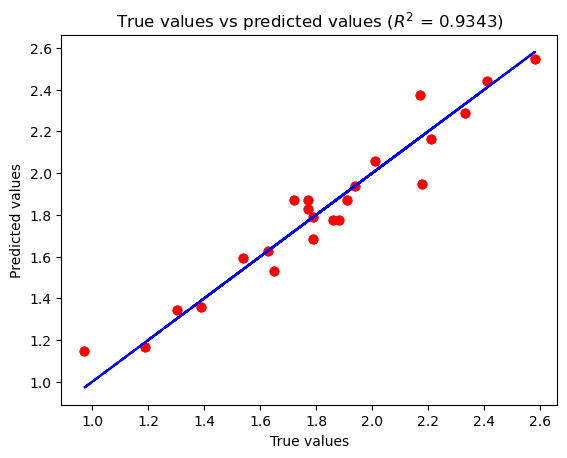

RMSE: 0.3987658665872867
r2: -3.96017091114554


In [97]:
evaluate_model(lr, X_train, y_true_train, mode="plot")
RMSE, r2 = evaluate_model(lr, X_test, y_true_test, mode="metrics")
print(f"RMSE: {RMSE}")
print(f"r2: {r2}")

$\quad$**选做任务**: 所选参数是足够合理的吗? 一方面, 实验数据本身可能就带有噪声; 另一方面, 所选取的几何参数数目还是过多了. 事实上, 若想进一步对特征进行降维(或挑选), 还可以有很多策略, 例如:

- 主元分析法(PCA, 将在后续课程学到).
- $L_1$-正则化. 理论课已经讲过, $L_1$-范数约束相比于$L_2$-范数约束更易产生稀疏解, 我们借助正则化强度的控制, 可以让很多参数变为0, 对应的那些分量就相应被舍弃, 达到**特征选择**(feature selection)的目的.
- 根据各个特征可以解释的数据方差大小进行特征选择, 详情可阅读[`sklearn.feature_selection`](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection)模块的官方文档.

你可以选择在下面的代码块中自由实践你感兴趣的特征选择方法, 并在注释的答题区中给出你的讨论.

In [ ]:


### 选做任务答题区(另起一行时请记得加注释符号#) ###
### BEGIN YOUR SOLUTION ###
# 
### END YOUR SOLUTION ###

# 结果分析

$\quad$**任务4**: 运行下面的代码块, 根据参数正负, 考察各个因素对对映选择性的影响, 在注释的答题区中写下你的分析.
- $\pi$-$\pi$堆积作用如何影响对映选择性? (从几何结构与能量两方面考虑) 这符合你的直觉吗?
- 烷基的几何参数如何影响对映选择性? 和芳基几何参数相比, 总体看, 谁的影响更大?

### 提示
- $\Delta \Delta G^\ddagger$越大, 表明两种对映异构体的动力学活性相差越大, 于是对映选择性越好.
- 你可能会得到一些反直觉的结果, 但这是模型过拟合(特征数目过多)导致的问题, 请如实地反映输出结果, 并写出你的疑惑.

In [30]:
lr.coef_

### 任务4答题区(另起一行时请记得加注释符号#) ###
### BEGIN YOUR SOLUTION ###
# 环间距越大对映选择性越好，电子结构能量越低，对映选择性越低。
# 总体来看烷基的几何参数的影响远大于芳基几何参数的影响，其中烷基的长度越长，对映选择性越好。综合宽度最大最小值的影响，烷基越宽会使得对映选择性变差。
# 芳环的几何参数影响相对烷基较低，且总体而言其几何参数越大，对映选择性变差。
### END YOUR SOLUTION ###

array([ 0.2816149 , -2.5204299 ,  2.21799803,  0.73812735,  0.16464213,
       -0.7321698 , -0.06070699, -0.03168404, -0.12143153])